<h2>TimeSeries Forecasting on Climate Dataset</h2>

<img src="dataset-cover.jpg" alt="Alt Text" width="3000" />

The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. The 4 parameters here are
meantemp, humidity, wind_speed, meanpressure.

__Column__

* **meantemp**: Mean temperature averaged out from multiple 3 hour intervals in a day.

* **humidity**: Humidity value for the day (units are grams of water vapor per cubic meter volume of air).

* **wind_speed**: Wind speed measured in kmph.

* **meanpressure**: Pressure reading of weather (measure in atm).


In [91]:
# Importing Required Libraries

import pandas as pd # data preprocessing
import numpy as np # numerical computation

import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # for model evaluation
import math # mathematical operations
from datetime import datetime,date # for date and time operations
from statsmodels.tsa.stattools import adfuller # for stationarity check
from statsmodels.tsa.seasonal import seasonal_decompose # for decomposition of time series
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

import warnings # ignoring warnings
warnings.filterwarnings('ignore')

np.random.seed(5) # reproducibility

In [92]:
# Importing the dataset
df = pd.read_csv('DailyDelhiClimate.csv')

In [93]:
# Checking the first 5 rows of the dataset
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [94]:
# No of Rows and Columns in the train dataset
print("Number of rows in dataset is = ", df.shape[0], " \nNumber of columns in dataset is = " , df.shape[1])


Number of rows in dataset is =  1462  
Number of columns in dataset is =  5


In [95]:
# Simplyfying the column names
df.columns = ['date', 'm_temp', 'humidity', 'wind_speed', 'm_pressure']

# Trying out all the features to forecast the  mean temperature
target = ['m_temp']
features = [feature for feature in df.columns if feature not in target]
features

['date', 'humidity', 'wind_speed', 'm_pressure']

<h3>1.Data Visualization</h3>

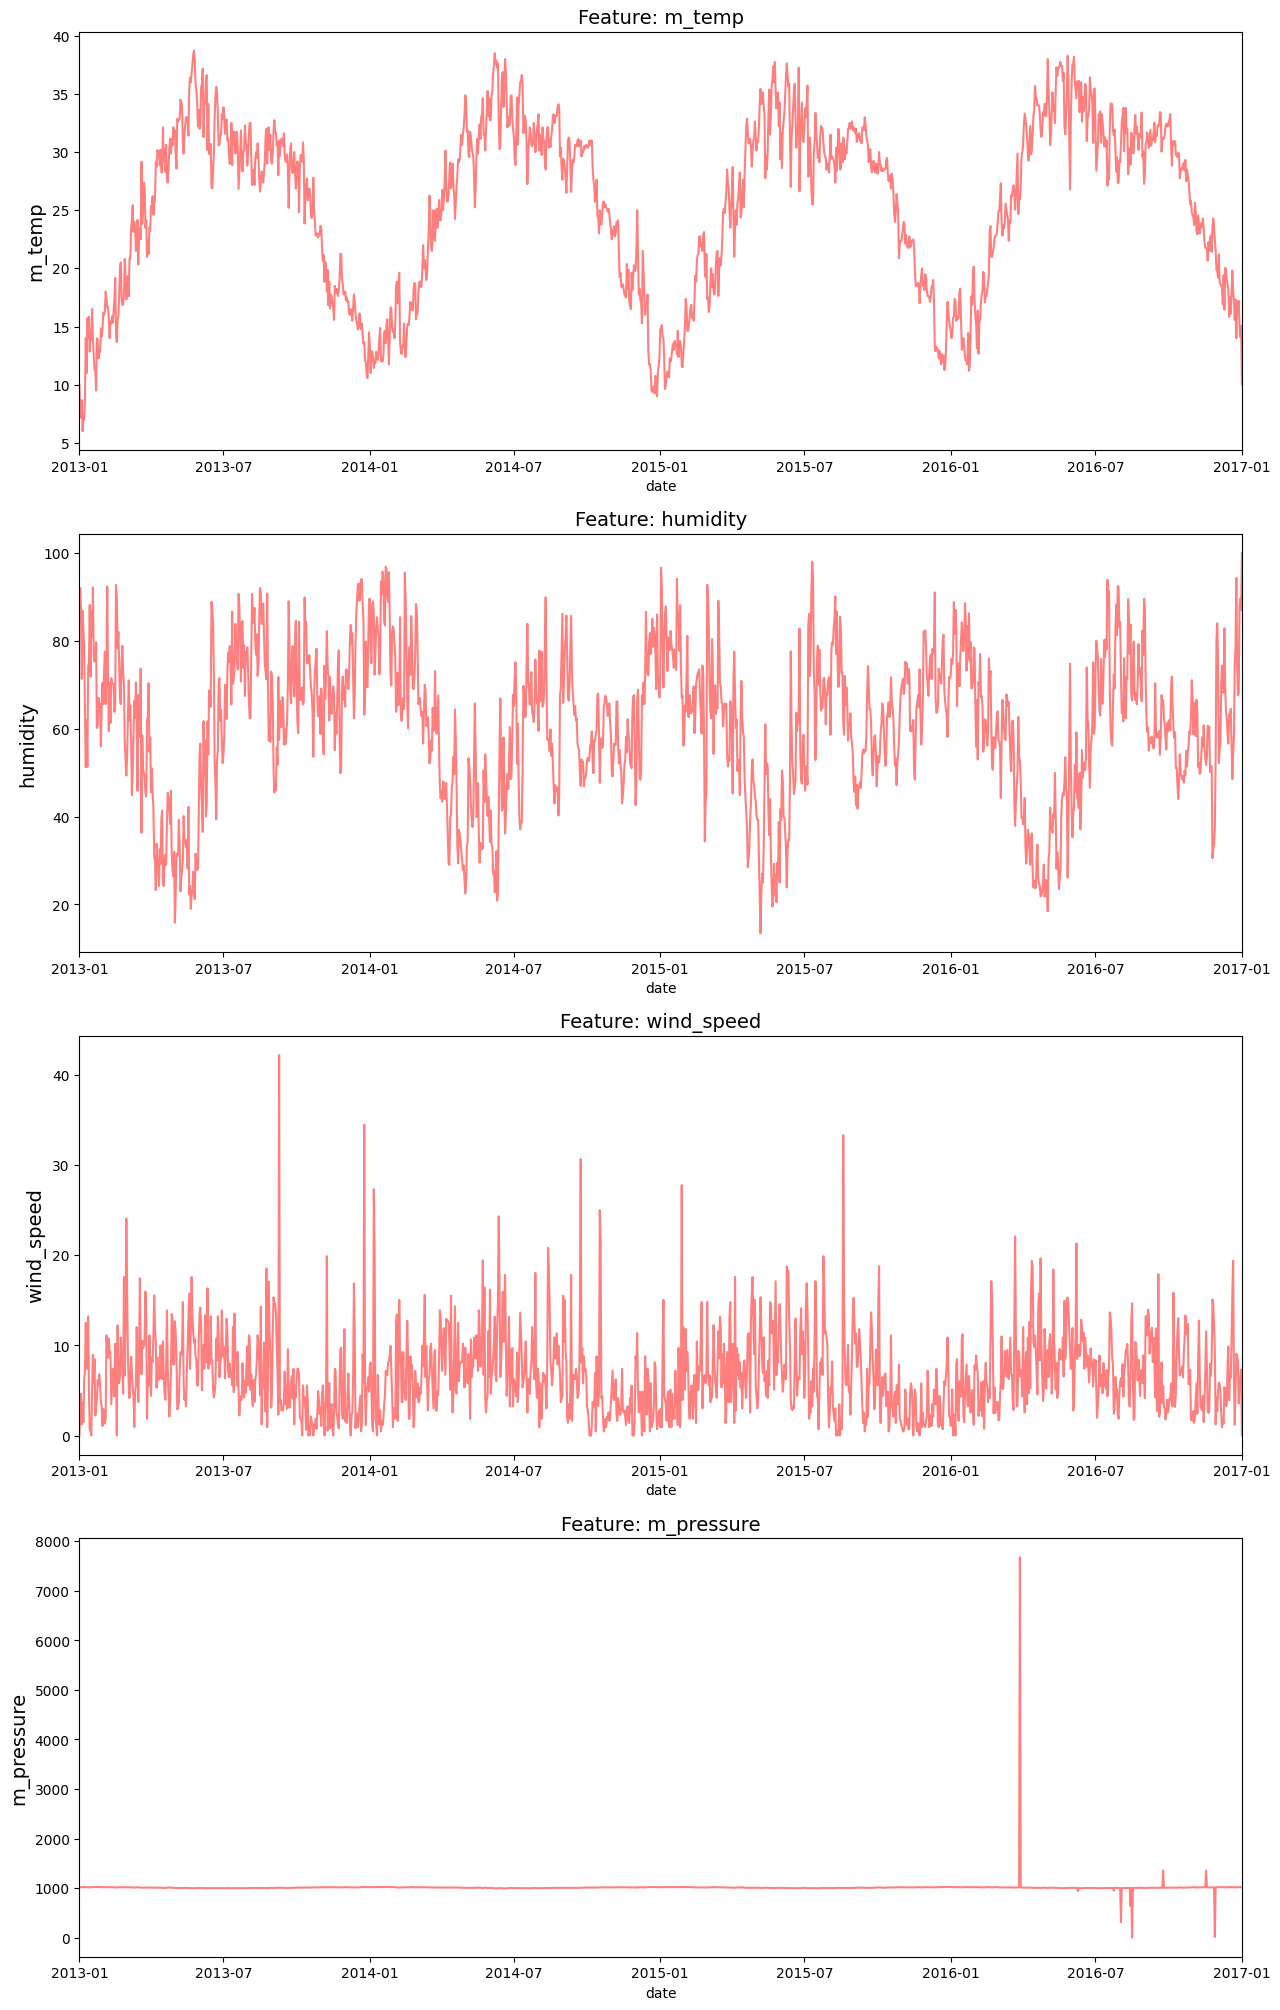

In [96]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

data = df.copy()

# To complete the data as naive method, we will use ffill
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

for i, column in enumerate(data.drop('date', axis=1).columns):
    sns.lineplot(x=data['date'], y=data[column].fillna(method='ffill'), ax=ax[i], color='red',alpha=0.5)
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([datetime(2013, 1, 1), datetime(2017, 1, 1)])

Observations:
* From the above plots, we can see that m_pressure remains constant most of the time.m_pressure doesn't contribute much for our forecasting models.

In [97]:
#removing m_pressure from the features and from the dataframe
df.drop('m_pressure', axis=1, inplace=True)
features = [feature for feature in features if feature != 'm_pressure']
features

['date', 'humidity', 'wind_speed']

<h3>2.Data Preprocessing</h3>

In [98]:
#Checking Chronological Order and Equidistant Timestamps
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2013-01-01,NaT
1,2013-01-02,1 days
2,2013-01-03,1 days
3,2013-01-04,1 days
4,2013-01-05,1 days


In [99]:
df['delta'].sum(), df['delta'].count()
# The sum of the delta column is 1462 days and the count of the delta column is 1462. This means that there are 1462 days in the dataset and the timestamps are equidistant.    

(Timedelta('1461 days 00:00:00'), 1461)

In [100]:
# Remove the delta column from the dataframe
df.drop('delta', axis=1, inplace=True)

In [101]:
# checking for Missing Values
df.isna().sum()

date          0
m_temp        0
humidity      0
wind_speed    0
dtype: int64

* If in case any missing values present in the dataset we can use Interpolate, bfill and ffill methods to fill the nan values, The results of different methods are plotted for comparison.

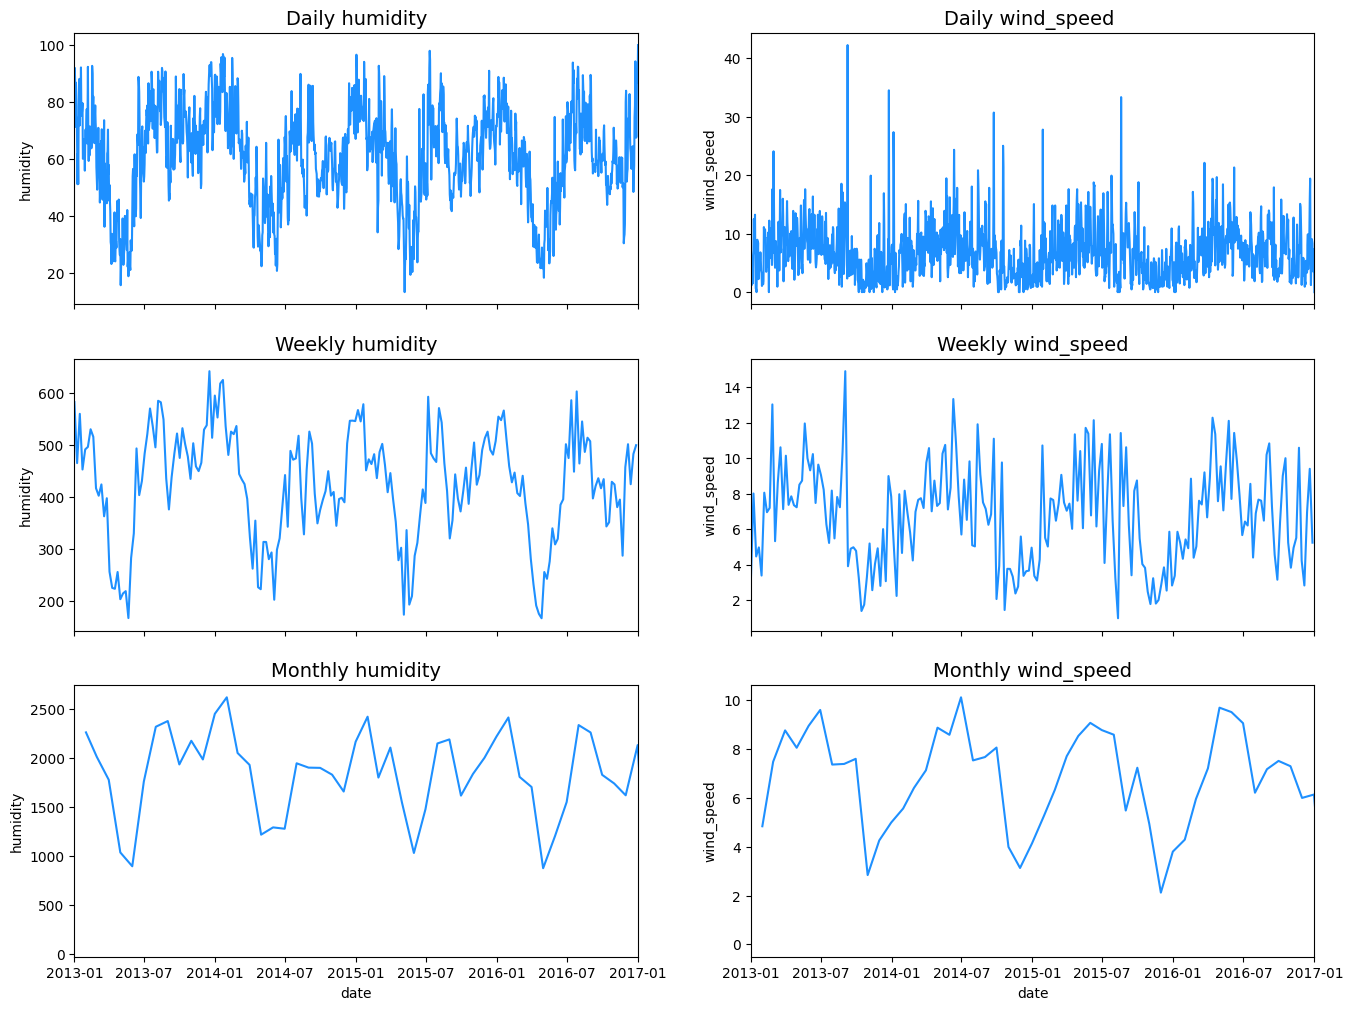

In [102]:
# Checking for resampling
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(x=df['date'], y=df['humidity'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Daily humidity', fontsize=14)

resampled_df = df[['date','humidity']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['humidity'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly humidity', fontsize=14)

resampled_df = df[['date','humidity']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['humidity'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly humidity', fontsize=14)

for i in range(3):
    ax[i,0].set_xlim([datetime(2013, 1, 1), datetime(2017, 1, 1)])

sns.lineplot(x=df['date'], y=df['wind_speed'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily wind_speed ', fontsize=14)

resampled_df = df[['date','wind_speed']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['wind_speed'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly wind_speed', fontsize=14)

resampled_df = df[['date','wind_speed']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['wind_speed'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly wind_speed', fontsize=14)

for i in range(3):
    ax[i,1].set_xlim([datetime(2013, 1, 1), datetime(2017, 1, 1)])
plt.show()

Observations:
* The different frequencies of plots shows that resampling to weekly data will smooth the data by reducing Noise.

In [103]:
downsample = df[['date',
                 'humidity', 
                 'wind_speed',
                 'm_temp', 
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

In [104]:
# Displaying weekly data
df.head()

,date,humidity,wind_speed,m_temp
0,2013-01-01,83.295238,2.903810,7.604762
1,2013-01-08,66.511905,8.013265,13.176871
2,2013-01-15,80.068027,4.471905,13.409524
3,2013-01-22,64.748299,4.981973,12.848639
4,2013-01-29,70.279592,3.396378,16.107653


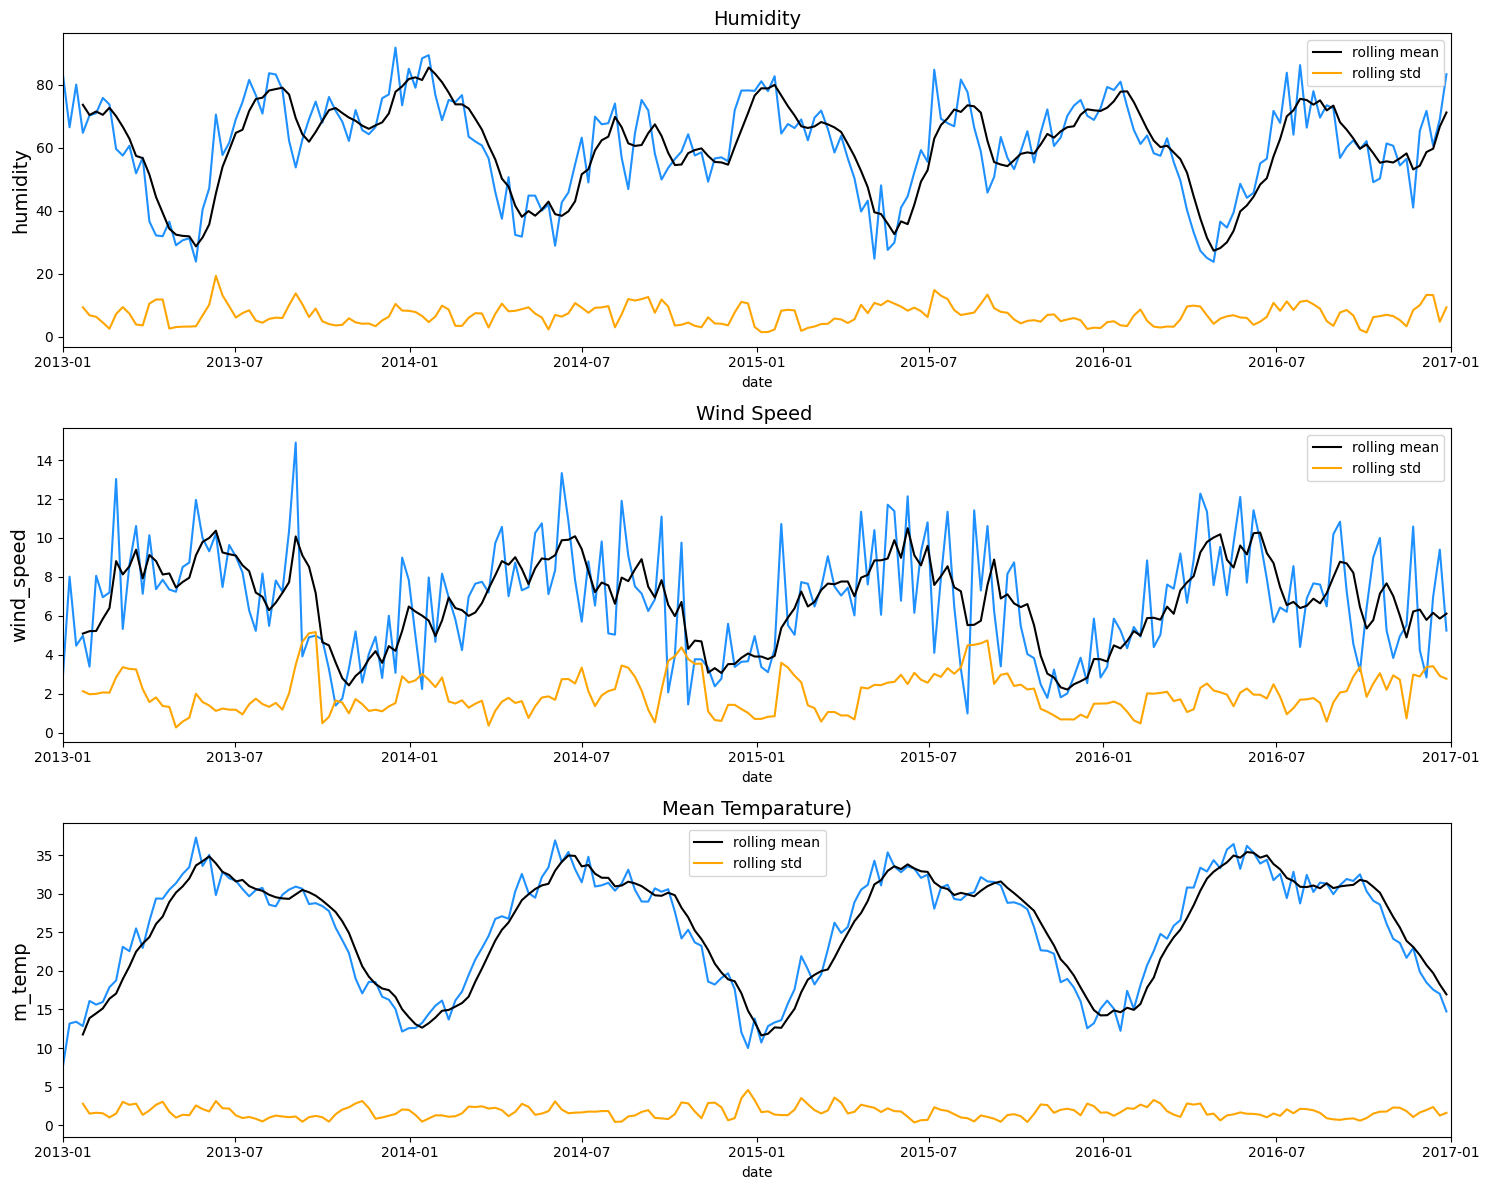

In [105]:
# Checking for Stationarity
'''

The check for stationarity can be done via three different approaches:

    visually: plot time series and check for trends or seasonality
    basic statistics: split time series and compare the mean and variance of each partition
    statistical test: Augmented Dickey Fuller test
'''

# basic statistics

rolling_window = 4 #  Iam choosing 4 weeks as the window size because the data is weekly and there are around 4 weeks in a month.
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['humidity'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['humidity'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['humidity'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Humidity', fontsize=14)
ax[0].set_ylabel(ylabel='humidity', fontsize=14)
ax[0].set_xlim([datetime(2013, 1, 1), datetime(2017, 1, 1)])

sns.lineplot(x=df['date'], y=df['wind_speed'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['wind_speed'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['wind_speed'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Wind Speed ', fontsize=14)
ax[1].set_ylabel(ylabel='wind_speed', fontsize=14)
ax[1].set_xlim([datetime(2013, 1, 1), datetime(2017, 1, 1)])

sns.lineplot(x=df['date'], y=df['m_temp'], ax=ax[2], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['m_temp'].rolling(rolling_window).mean(), ax=ax[2], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['m_temp'].rolling(rolling_window).std(), ax=ax[2], color='orange', label='rolling std')
ax[2].set_title('Mean Temparature)', fontsize=14)
ax[2].set_ylabel(ylabel='m_temp', fontsize=14)
ax[2].set_xlim([datetime(2013, 1, 1), datetime(2017, 1, 1)])

plt.tight_layout()
plt.show()

Observations:
* The mean and standard deviation of the plots can be seen from the above plots and can be used to check the Stationarity of the data before passing the data into the model.
* The exact inferences about Stationarity cannot be drawn by seeing visually.

In [106]:
# statistical test like Augmented dickey fuller test is used to determine the stationarity.

result = adfuller(df['wind_speed'])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('no of lags used: {}'.format(result[2]))
print('no of observations used : {}'.format(result[3]))
print('Critical Values: {}'.format(result[4]))

ADF Statistic: -3.0924613439068973
p-value: 0.027116136355343576
no of lags used: 4
no of observations used : 204
Critical Values: {'1%': -3.462818103072159, '5%': -2.8758145932936805, '10%': -2.574378674548251}


Observations:
* From the above test results , we can say wind speed data is stationary with 95 percent confidence.

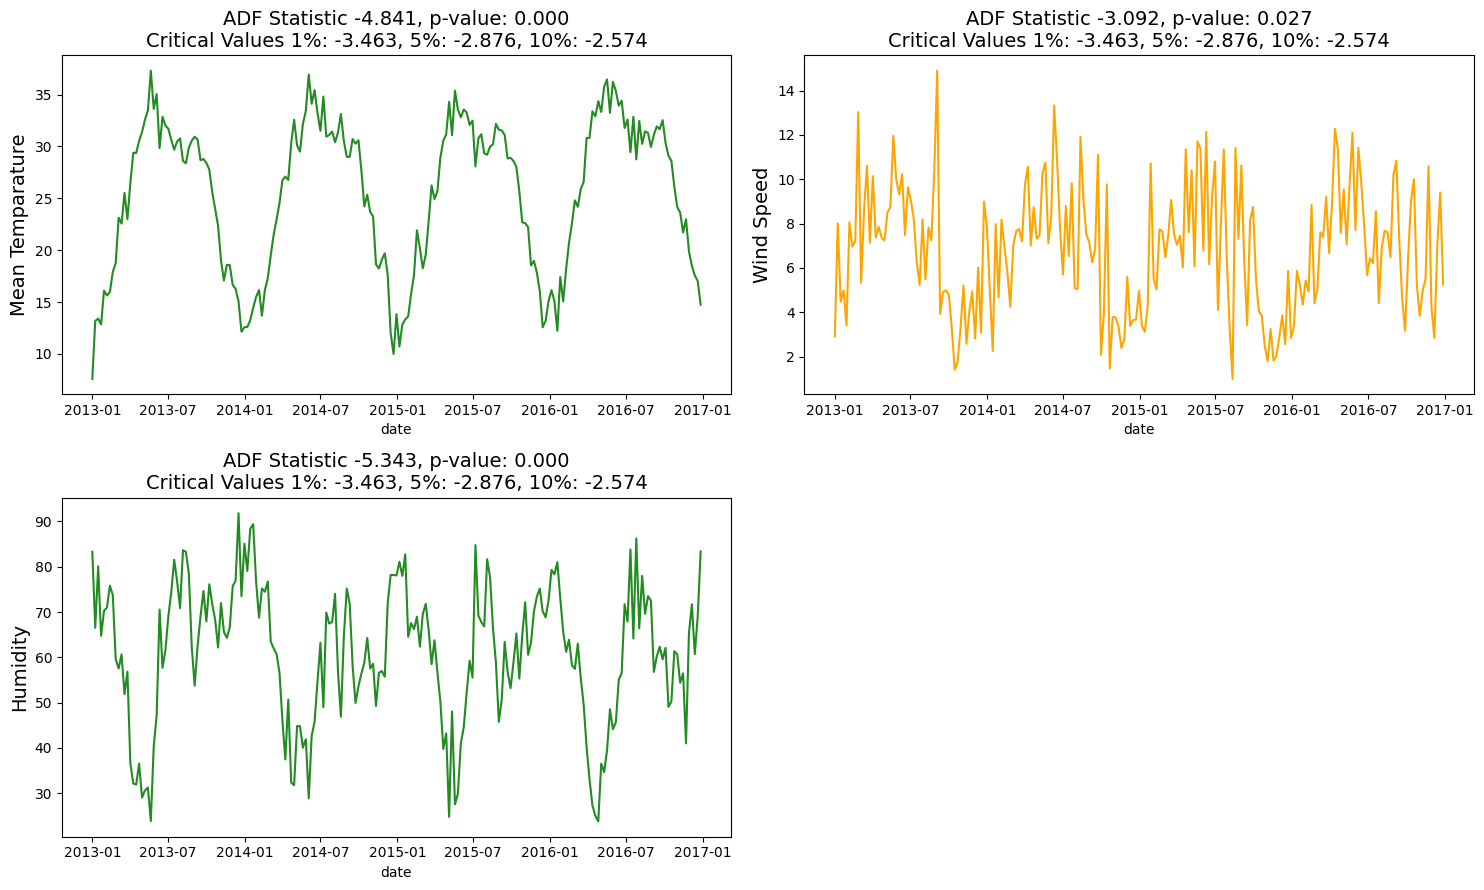

In [107]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['m_temp'].values, 'Mean Temparature', ax[0, 0])
visualize_adfuller_results(df['humidity'].values, 'Humidity', ax[1, 0])
visualize_adfuller_results(df['wind_speed'].values, 'Wind Speed', ax[0, 1])

f.delaxes(ax[1, 1])
plt.tight_layout()
plt.show()

Observations:
* we can conclude that WindSpeed, Mean Temperature and Humidity are Stationary
* Outliers maybe present for in the dataset

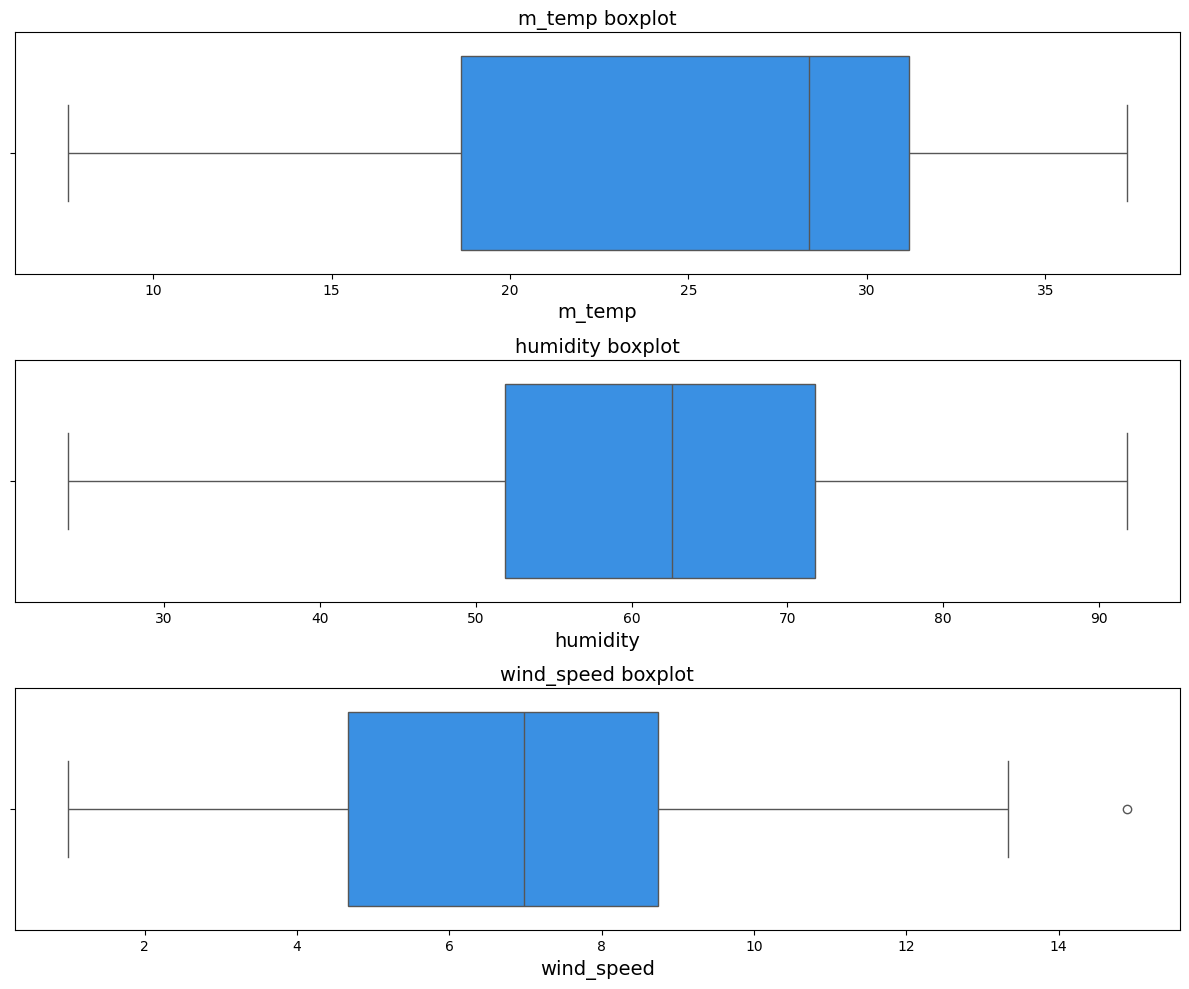

In [108]:
# Checking for any potential outliers in the data that may cause unnecessary Noise
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

for i, column in enumerate(['m_temp', 'humidity', 'wind_speed']):
    sns.boxplot(x=df[column], ax=ax[i], color='dodgerblue')
    ax[i].set_title(f'{column} boxplot', fontsize=14)
    ax[i].set_xlabel(xlabel=column, fontsize=14)
    
plt.tight_layout()
plt.show()

* wind speed has outliers in it, so we should deal with it

In [109]:
#  Treating Outliers in the dataset
Q1 = df['wind_speed'].quantile(0.25)
Q3 = df['wind_speed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['wind_speed_new'] = np.clip(df['wind_speed'], lower_bound, upper_bound)


The below blocks of code can be used to Transform the Mean Temperature data from non-Stationary to Stationary because Mean Temperature is our target feature for forecasting.But in our data the mean Temperature feature is Stationary so no need for transformation

In [110]:
# # Converting the data to Stationary
# # Log Transform of absolute values
# # (Log transoform of negative values will return NaN)
# df['m_temp_log'] = np.log(abs(df['m_temp']))

# f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# visualize_adfuller_results(df['m_temp_log'], 'Transformed \n Mean Temparature', ax[0])

# sns.kdeplot(df['m_temp_log'], ax=ax[1], color='dodgerblue')

In [111]:
# # First Order Differencing
# ts_diff = np.diff(df['m_temp'])
# df['m_temp_diff_1'] = np.append([0], ts_diff)

# f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
# visualize_adfuller_results(df['m_temp_diff_1'], 'Differenced (1. Order) \n Mean Temparature', ax)

<h3>3.Feature Engineering</h3>

In [112]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2013-01-01,2013,1,1,1,1,1,1
1,2013-01-08,2013,1,8,8,2,1,1
2,2013-01-15,2013,1,15,15,3,1,1
3,2013-01-22,2013,1,22,22,4,1,1
4,2013-01-29,2013,1,29,29,5,1,1


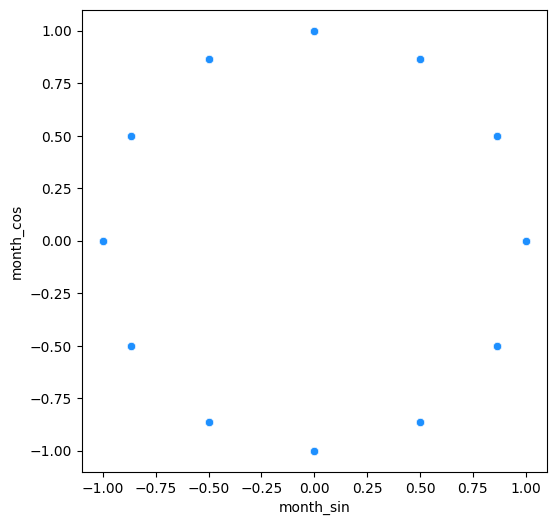

In [113]:
#Encoding Cyclical Features

month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

* The cyclic features should be engineered such that the model understands the cyclic data present in the dataset.
* These features are are mainly used to pass into the machine learning models unlike traditional models which comprehends the cyclic nature of the data.

In [114]:
# Time series Decomposition for further analysis

core_columns = ['m_temp', 'humidity', 'wind_speed']

for column in core_columns:
    decomposition = seasonal_decompose(df[column], model='additive', period=52)
    df[f'{column}_trend'] = decomposition.trend
    df[f'{column}_seasonal'] = decomposition.seasonal
    df[f'{column}_resid'] = decomposition.resid


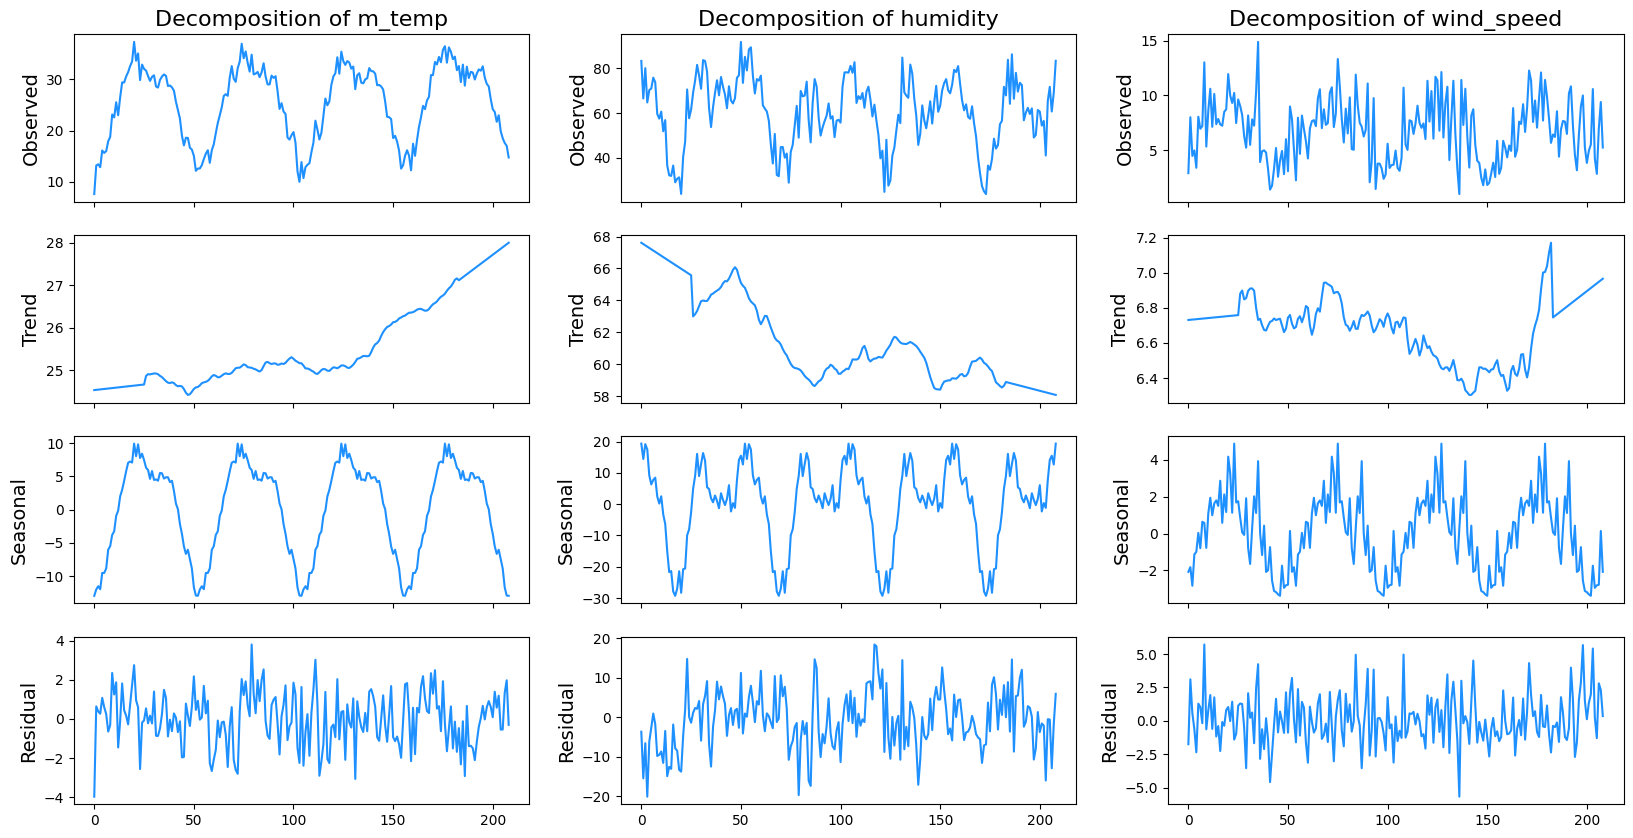

In [115]:
fig, ax = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(20,10))

for i, column in enumerate(core_columns):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

Observation:
* Eventhough the data is stationary we can still see trend and seasonality above. This is because seasonal_decompose may simply reflect residual periodic variations in the data that were not fully removed.
* We should check for residuals stationarity to see if our transformations are correct


In [116]:
pd.set_option('display.max_columns', None) #To display all columns in dataset
df.head()

,date,humidity,wind_speed,m_temp,wind_speed_new,year,month,day,day_of_year,week_of_year,quarter,season,month_sin,month_cos,m_temp_trend,m_temp_seasonal,m_temp_resid,humidity_trend,humidity_seasonal,humidity_resid,wind_speed_trend,wind_speed_seasonal,wind_speed_resid
0,2013-01-01,83.295238,2.903810,7.604762,2.903810,2013,1,1,1,1,1,1,0.5,0.866025,NaN,-11.508837,NaN,NaN,17.217284,NaN,NaN,-1.375411,NaN
1,2013-01-08,66.511905,8.013265,13.176871,8.013265,2013,1,8,8,2,1,1,0.5,0.866025,NaN,-12.198759,NaN,NaN,18.465272,NaN,NaN,-2.661745,NaN
2,2013-01-15,80.068027,4.471905,13.409524,4.471905,2013,1,15,15,3,1,1,0.5,0.866025,NaN,-11.629770,NaN,NaN,20.228956,NaN,NaN,-2.827694,NaN
3,2013-01-22,64.748299,4.981973,12.848639,4.981973,2013,1,22,22,4,1,1,0.5,0.866025,NaN,-12.036580,NaN,NaN,23.052768,NaN,NaN,-0.735973,NaN
4,2013-01-29,70.279592,3.396378,16.107653,3.396378,2013,1,29,29,5,1,1,0.5,0.866025,NaN,-9.859661,NaN,NaN,10.101909,NaN,NaN,-0.002526,NaN


In [117]:
days_in_month = 1

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2d'] = df[f'{column}_seasonal'].shift(-2 * days_in_month)
    df[f'{column}_seasonal_shift_b_1d'] = df[f'{column}_seasonal'].shift(-1 * days_in_month)
    df[f'{column}_seasonal_shift_1d'] = df[f'{column}_seasonal'].shift(1 * days_in_month)
    df[f'{column}_seasonal_shift_2d'] = df[f'{column}_seasonal'].shift(2 * days_in_month)
    df[f'{column}_seasonal_shift_3d'] = df[f'{column}_seasonal'].shift(3 * days_in_month)

* Lags are used as features in time series forecasting because they capture past information that can help predict future values.
* These lags helps model to capture the autocorrelation in machine learning models.

In [118]:
df.head()

,date,humidity,wind_speed,m_temp,wind_speed_new,year,month,day,day_of_year,week_of_year,quarter,season,month_sin,month_cos,m_temp_trend,m_temp_seasonal,m_temp_resid,humidity_trend,humidity_seasonal,humidity_resid,wind_speed_trend,wind_speed_seasonal,wind_speed_resid,m_temp_seasonal_shift_b_2d,m_temp_seasonal_shift_b_1d,m_temp_seasonal_shift_1d,m_temp_seasonal_shift_2d,m_temp_seasonal_shift_3d,humidity_seasonal_shift_b_2d,humidity_seasonal_shift_b_1d,humidity_seasonal_shift_1d,humidity_seasonal_shift_2d,humidity_seasonal_shift_3d,wind_speed_seasonal_shift_b_2d,wind_speed_seasonal_shift_b_1d,wind_speed_seasonal_shift_1d,wind_speed_seasonal_shift_2d,wind_speed_seasonal_shift_3d
0,2013-01-01,83.295238,2.903810,7.604762,2.903810,2013,1,1,1,1,1,1,0.5,0.866025,NaN,-11.508837,NaN,NaN,17.217284,NaN,NaN,-1.375411,NaN,-11.629770,-12.198759,NaN,NaN,NaN,20.228956,18.465272,NaN,NaN,NaN,-2.827694,-2.661745,NaN,NaN,NaN
1,2013-01-08,66.511905,8.013265,13.176871,8.013265,2013,1,8,8,2,1,1,0.5,0.866025,NaN,-12.198759,NaN,NaN,18.465272,NaN,NaN,-2.661745,NaN,-12.036580,-11.629770,-11.508837,NaN,NaN,23.052768,20.228956,17.217284,NaN,NaN,-0.735973,-2.827694,-1.375411,NaN,NaN
2,2013-01-15,80.068027,4.471905,13.409524,4.471905,2013,1,15,15,3,1,1,0.5,0.866025,NaN,-11.629770,NaN,NaN,20.228956,NaN,NaN,-2.827694,NaN,-9.859661,-12.036580,-12.198759,-11.508837,NaN,10.101909,23.052768,18.465272,17.217284,NaN,-0.002526,-0.735973,-2.661745,-1.375411,NaN
3,2013-01-22,64.748299,4.981973,12.848639,4.981973,2013,1,22,22,4,1,1,0.5,0.866025,NaN,-12.036580,NaN,NaN,23.052768,NaN,NaN,-0.735973,NaN,-9.704554,-9.859661,-11.629770,-12.198759,-11.508837,6.015321,10.101909,20.228956,18.465272,17.217284,-0.195819,-0.002526,-2.827694,-2.661745,-1.375411
4,2013-01-29,70.279592,3.396378,16.107653,3.396378,2013,1,29,29,5,1,1,0.5,0.866025,NaN,-9.859661,NaN,NaN,10.101909,NaN,NaN,-0.002526,NaN,-8.900452,-9.704554,-12.036580,-11.629770,-12.198759,6.308852,6.015321,23.052768,20.228956,18.465272,-0.937108,-0.195819,-0.735973,-2.827694,-2.661745


<h3>4.Exploratory Data Analysis</h3>

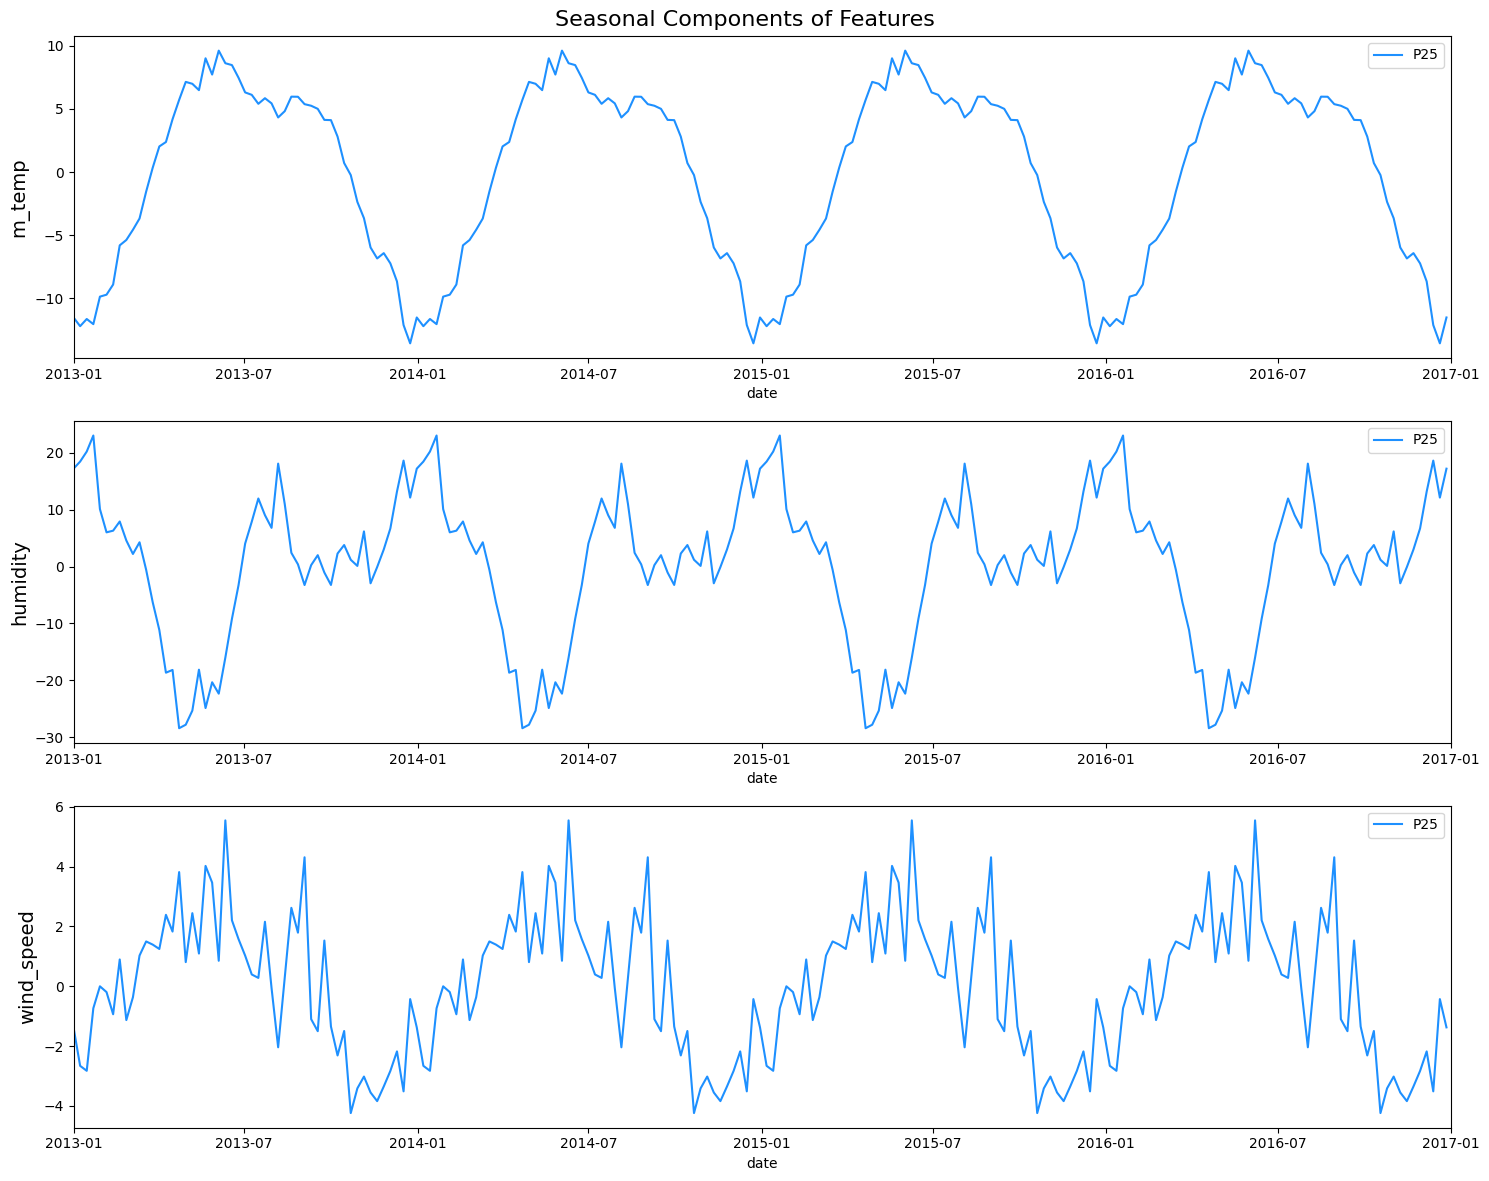

In [119]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2013, 1, 1), date(2017, 1, 1)])
    
plt.tight_layout()
plt.show()

Obseravtions:
  * Mean Temperature reaches its maximum around May/June and its minimum around December/January every year.
  * The maximum humidity is around February/March , maintains somewhat constant at september/october and lowest humidity is around April/May.
  * Minimum Wind Speed is around Novomber/December and Maximum is around May, But there are some anamolies present in it.

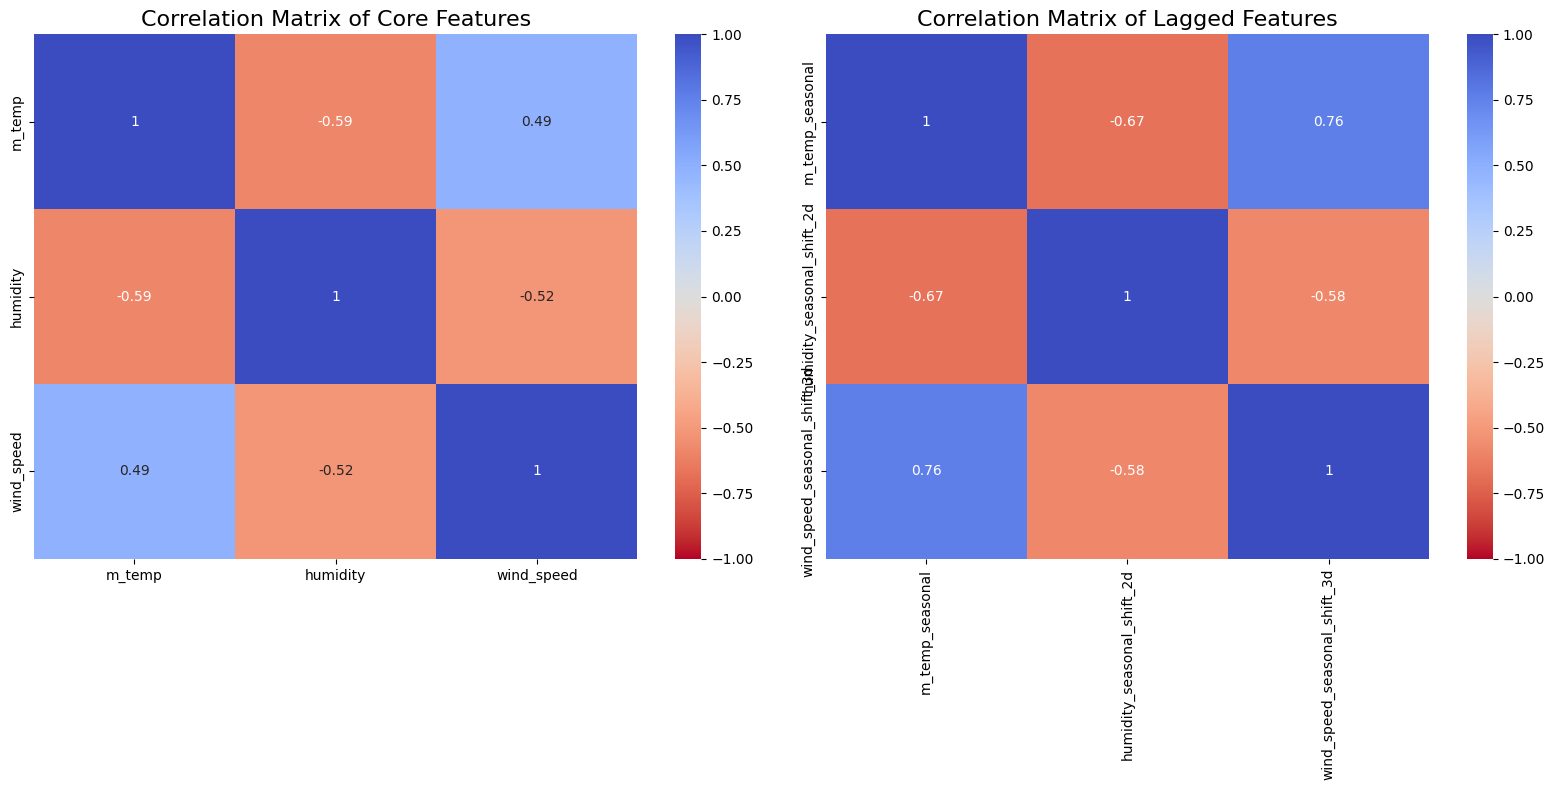

In [120]:
# Correlation Matrix
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'm_temp_seasonal',         
    'humidity_seasonal_shift_2d', 
    'wind_speed_seasonal_shift_3d'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

Observations:
* features are higher correlated in the case of shifted features (lagged ones) than the original ones.
* Mean Temperature is more correlated to humidity than wind speed.

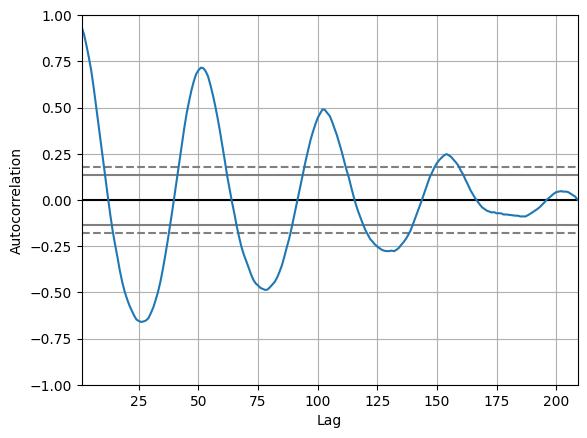

In [121]:
# Autocorrelation Analysis
# Checking Autocorrelation of target feature

autocorrelation_plot(df['m_temp'])
plt.show()

Observations:
* The Plot shows Peaks at regular intervals which suggest seasonality or periodic trends.
* The dashed lines represent the confidence interval.Any points outside these lines indicate statistically significant correlations

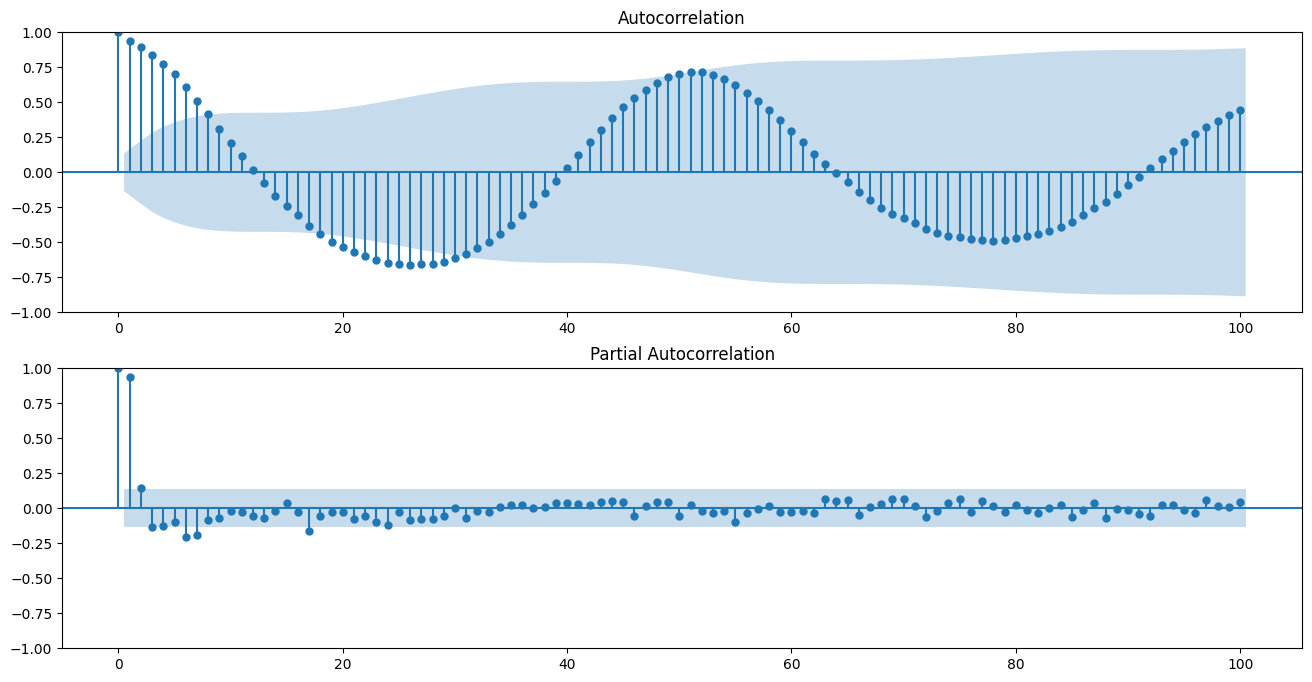

In [122]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['m_temp'], lags=100, ax=ax[0])
plot_pacf(df['m_temp'], lags=100, ax=ax[1])

plt.show()

Observations:
* The Autocorrelation Function (ACF) shows how current values are correlated with past values (lags).
* The Partial Autocorrelation Function (PACF) helps determine the order of an AutoRegressive (AR) model by showing the direct correlation of a time series with its past values after removing intermediate dependencies.
* We need to consider the lags above the blue shaded region for our model and choose the best model with fewer number of parameters.

<h3>5.Modeling</h3>
Time series can be either univariate or multivariate:

1. Univariate time series only has a single time-dependent variable.
2. Multivariate time series have a multiple time-dependent variables.

But, first of all we are going to see how does cross-validation technique works in TimeSeries Analysis.

In [123]:
N_SPLITS = 3

X = df['date']
y = df['m_temp']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

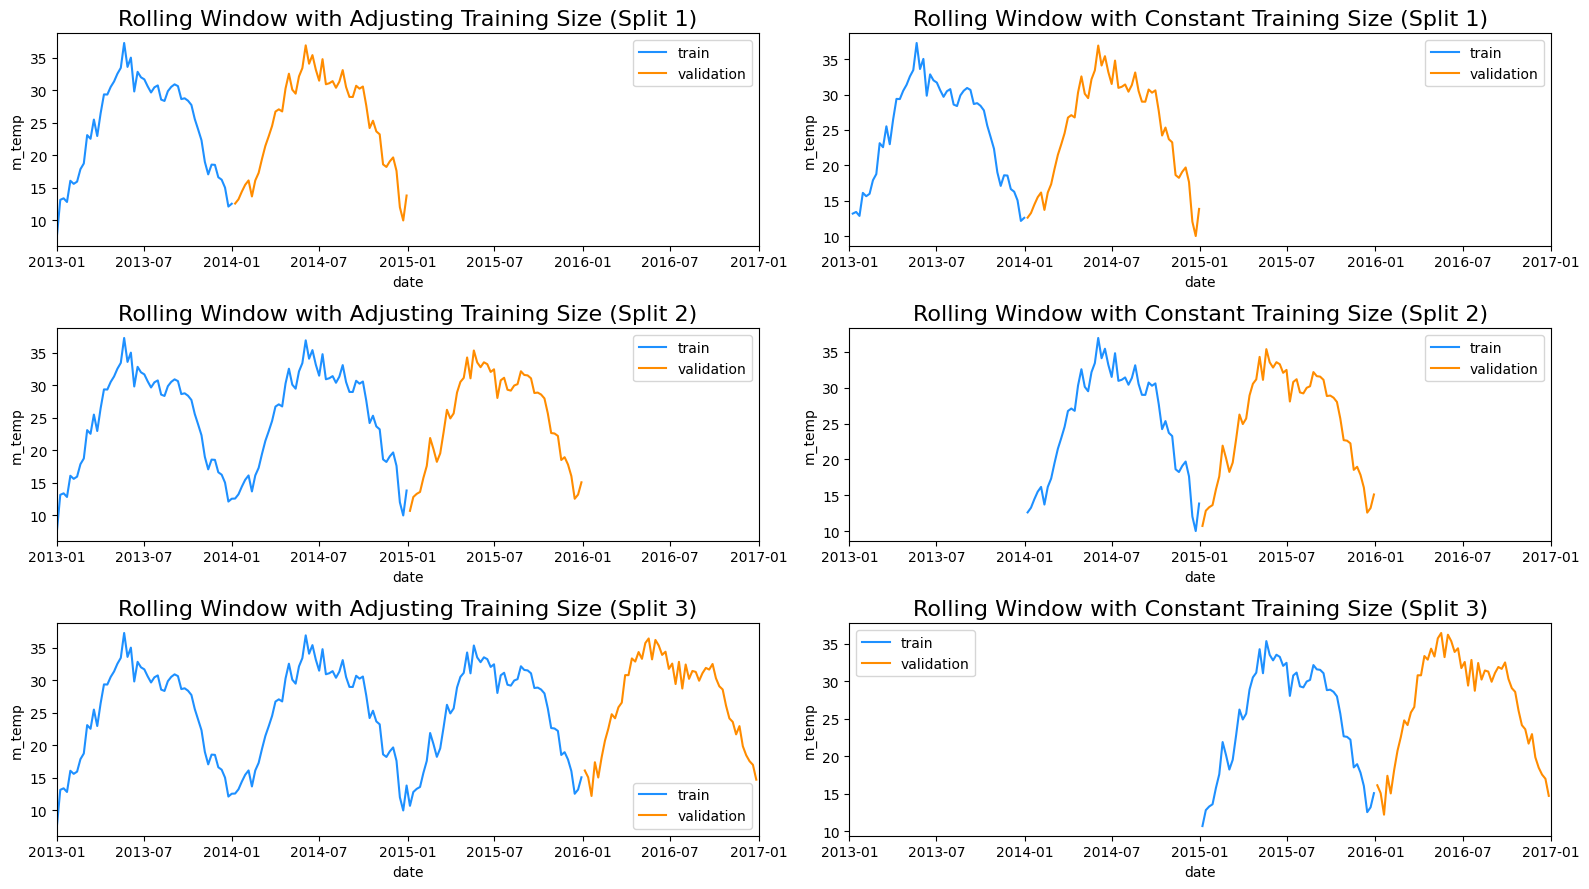

In [124]:

f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2013, 1, 1), date(2017, 1, 1)])
    ax[i, 1].set_xlim([date(2013, 1, 1), date(2017, 1, 1)])
    
plt.tight_layout()
plt.show()

* The above plots are the visualizations of how cross validation is done in TimeSeries Forecasting

### Univariate Analysis

In [125]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'm_temp']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(x_train), len(x_valid))

177 32


#### Auto Regressive Integrated Moving Average Model (ARIMA)

In [126]:

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order=order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

* The above function uses Akaike Information Criteria (AIC) to choose the best model with less number of parameters and more loglikelihood.
* The model with less AIC score is the best model.

In [127]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
best_params_aic = arima_optimizer_aic(y_train, pdq)

Best ARIMANone AIC=inf


In [128]:
arima_model = ARIMA(y_train, best_params_aic).fit()
y_pred_arima = arima_model.forecast(steps=32)
score_mae = mean_absolute_error(y_valid, y_pred_arima)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred_arima))

print('rmse: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))


rmse: 6.655820319399672
MAE: 6.108600080584969


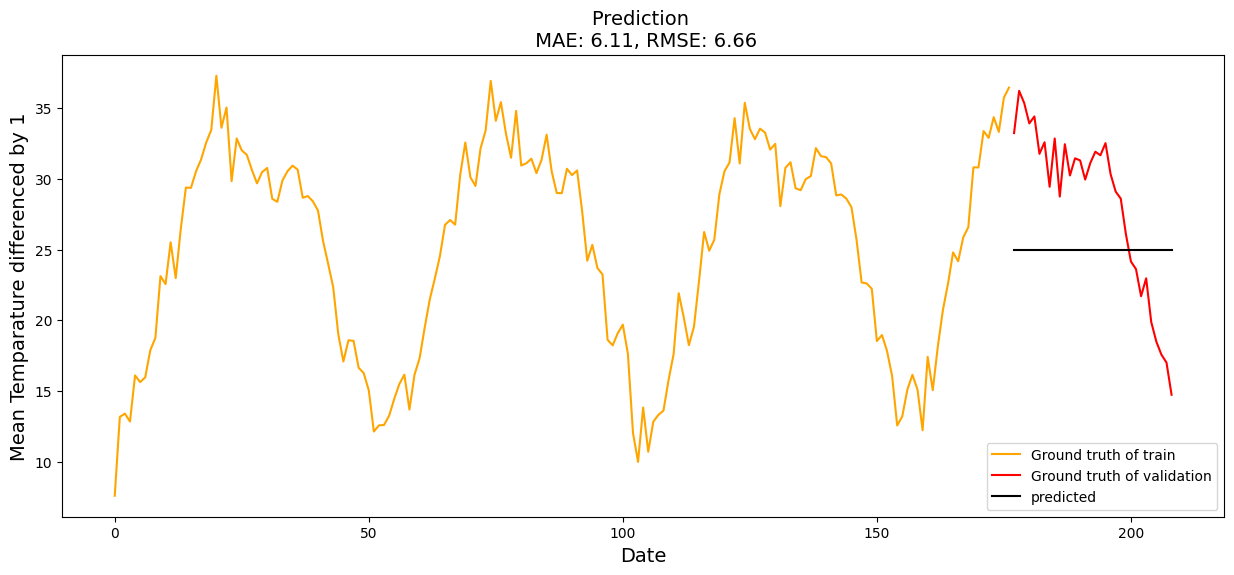

In [129]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)


sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax, color='orange', label='Ground truth of train') 
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='red', label='Ground truth of validation') 
sns.lineplot(y_pred_arima, label="predicted", color='black')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Mean Temparature differenced by 1', fontsize=14)

plt.show()

The flat prediction line indicates that the ARIMA model could not capture the seasonal fluctuations present in the dataset. This limitation arises because the ARIMA model is best suited for data with trends and cycles but without pronounced seasonality. For datasets like this one, where strong seasonal patterns are dominant, models like SARIMA (Seasonal ARIMA) or Triple Exponential Smoothing (Holt-Winters) are better choices.

This graph clearly highlights that while ARIMA models are powerful for certain types of time series data, they are not ideal when dealing with data that has prominent seasonal components.

#### Seasonal Auto Regressive Integrated Moving Average Model (SARIMA)

In [130]:

 
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [131]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{} - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [132]:
best_order, best_seasonal_order = sarima_optimizer_aic(y_train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:1658.0634079598128
SARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC:1536.0127036810609
SARIMA(0, 0, 0)x(0, 1, 0, 52) - AIC:587.1559807070203
SARIMA(0, 0, 0)x(0, 1, 1, 52) - AIC:570.8602168758159
SARIMA(0, 0, 0)x(1, 0, 0, 52) - AIC:1077.088946726593
SARIMA(0, 0, 0)x(1, 0, 1, 52) - AIC:1061.1457484210603
SARIMA(0, 0, 0)x(1, 1, 0, 52) - AIC:577.1204696680121
SARIMA(0, 0, 0)x(1, 1, 1, 52) - AIC:572.0946063527177
SARIMA(0, 0, 1)x(0, 0, 0, 52) - AIC:1437.273661324767
SARIMA(0, 0, 1)x(0, 0, 1, 52) - AIC:1326.8342225878473
SARIMA(0, 0, 1)x(0, 1, 0, 52) - AIC:569.4447564988118
SARIMA(0, 0, 1)x(0, 1, 1, 52) - AIC:551.3712049216819
SARIMA(0, 0, 1)x(1, 0, 0, 52) - AIC:1019.194757136838
SARIMA(0, 0, 1)x(1, 0, 1, 52) - AIC:1000.1310219820932
SARIMA(0, 0, 1)x(1, 1, 0, 52) - AIC:558.0534962979436
SARIMA(0, 0, 1)x(1, 1, 1, 52) - AIC:552.9125968605556
SARIMA(0, 1, 0)x(0, 0, 0, 52) - AIC:768.0058368339444
SARIMA(0, 1, 0)x(0, 0, 1, 52) - AIC:764.7494127420164
SARIMA(0, 1, 0)x(0, 1, 

* The model with less AIC score is the best model.

In [133]:
model = SARIMAX(y_train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_sar = sarima_final_model.get_forecast(steps=32)

y_pred_sarima = y_pred_sar.predicted_mean

score_mae = mean_absolute_error(y_valid, y_pred_sarima)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred_sarima))

print('rmse: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

rmse: 1.7806416556951248
MAE: 1.4219201405991835


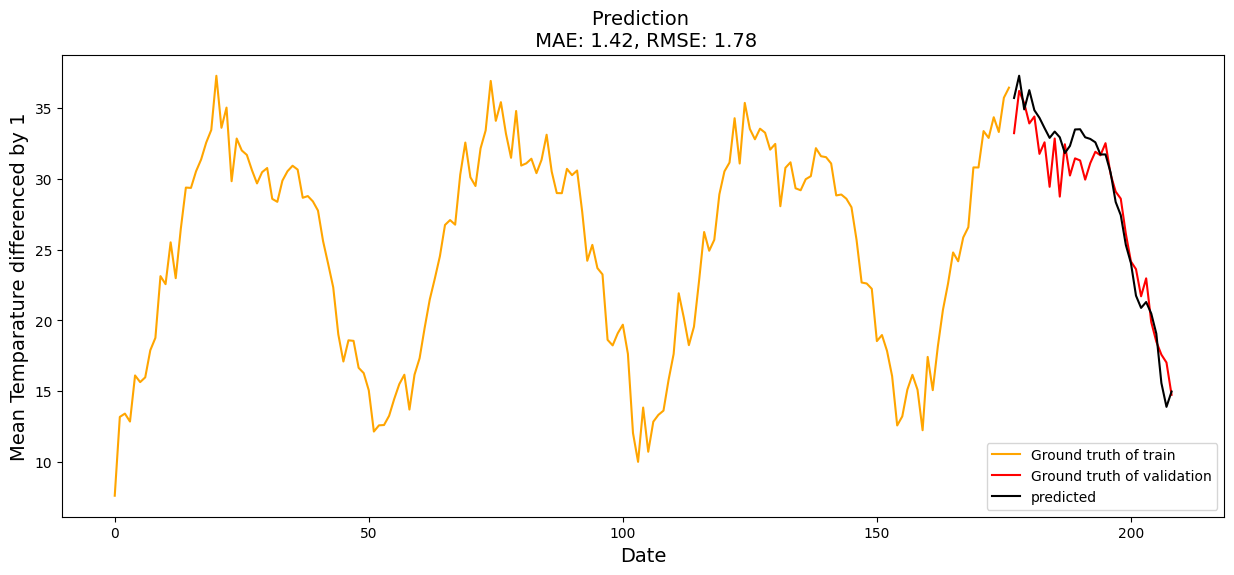

In [134]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)


sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax, color='orange', label='Ground truth of train') 
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='red', label='Ground truth of validation') 
sns.lineplot(y_pred_sarima, label="predicted", color='black')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Mean Temparature differenced by 1', fontsize=14)

plt.show()

The SARIMA model performs exceptionally well for this dataset, accurately capturing both trend and seasonality. The prediction line aligns closely with the actual test data, demonstrating the model’s strength in forecasting time series with clear seasonal cycles.

This graph confirms that for data with both seasonal and trend components, SARIMA is a highly effective model. Its flexibility in handling seasonality makes it a preferred choice for forecasting tasks where cycles and periodic patterns play a critical role in the data.

### Multivariate Analysis

#### Vector AutoRegression Model (VAR)

In [135]:
# The input data should be statioanry for this model
train_size = int(0.85 * len(df))

train_var, test_var = df[core_columns].iloc[:train_size], df[core_columns].iloc[train_size:]

#Fitting VAR Model
model = VAR(train_var)
selected_lag = model.select_order(maxlags=20)
optimal_lag = selected_lag.selected_orders['aic']
print("Optimal Lag (AIC):", optimal_lag)

model_fitted = model.fit(optimal_lag)

forecast_steps = len(test_var)
forecast = model_fitted.forecast(train_var.values[-optimal_lag:], steps=forecast_steps) #.values is used because VAR model works for Arrays.

forecast_df = pd.DataFrame(forecast, index=test_var.index, columns=df[core_columns].columns)

target_forecast = forecast_df['m_temp']

Optimal Lag (AIC): 7


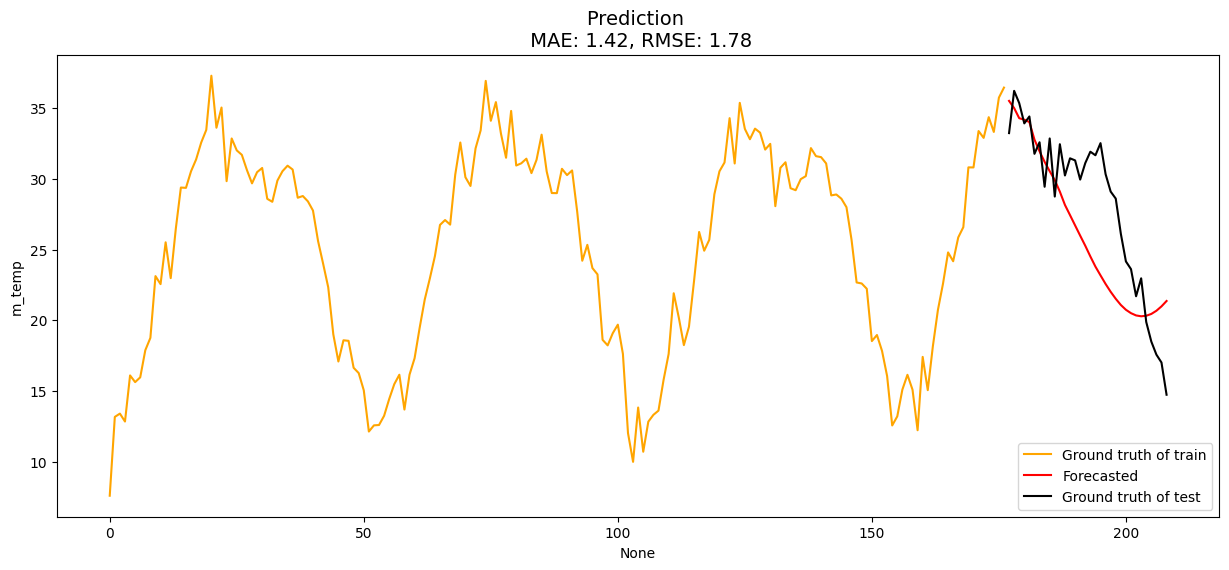

In [136]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)


sns.lineplot(x=train_var.index, y=train_var['m_temp'], ax=ax, color='orange', label='Ground truth of train') 
sns.lineplot(x=target_forecast.index, y=target_forecast, ax=ax, color='red', label='Forecasted') 
sns.lineplot(x=test_var.index, y=test_var['m_temp'],label="Ground truth of test", color='black')

var_score_mae = mean_absolute_error(target_forecast, test_var['m_temp'])
var_score_rmse = math.sqrt(mean_squared_error(target_forecast, test_var['m_temp']))

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)

plt.show()

* The VAR model gives a reasonable good predictions.

#### Long Short-Term Memory (LSTM)

For LSTM we are using daily data , because LSTM requires more data to perform well 

In [137]:
data.head()

,date,m_temp,humidity,wind_speed,m_pressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [138]:
# Ensure 'date' is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Set 'date' as index before resampling
data.set_index('date', inplace=True)

# Now, resample to hourly data and interpolate missing values
resampled_df = data.resample('H').interpolate(method='linear').reset_index()


* The data is resampled to hourly data using interpolate to increase the size of data for better performance.

In [139]:
# checking the size of the data
resampled_df.shape

(35065, 5)

In [140]:
resampled_df = resampled_df.drop('m_pressure',axis=1)
resampled_df = resampled_df.drop('date',axis=1)
resampled_df.head()

,m_temp,humidity,wind_speed
0,10.000000,84.5000,0.000000
1,9.891667,84.8125,0.124167
2,9.783333,85.1250,0.248333
3,9.675000,85.4375,0.372500
4,9.566667,85.7500,0.496667


In [141]:
# The input needs to be scaled before passing into the model
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(resampled_df)

In [142]:
def df_to_X_y(df, window_size=5):
  df_as_np = df
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0]]
    y.append(label)
  return np.array(X), np.array(y)

* The above function converts the input to the dimensions LSTM layer expects to be.

In [143]:
X, y = df_to_X_y(scaled_data)
X.shape, y.shape

((35060, 5, 3), (35060, 1))

In [144]:
X_train, y_train = X[:30000], y[:30000]
X_val, y_val = X[30000:32500], y[30000:32500]
X_test, y_test = X[32500:], y[32500:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((30000, 5, 3), (30000, 1), (2500, 5, 3), (2500, 1), (2560, 5, 3), (2560, 1))

In [145]:
# Building the model with Sequential api using LSTM layer.

model = Sequential()
model.add(keras.Input(shape=(5, 3)))
model.add(LSTM(32))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4608      
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,881
Trainable params: 4,881
Non-trainable params: 0
_________________________________________________________________


In [146]:
# Using ModelCheckPoint
# cp = ModelCheckpoint('model.keras', save_best_only=True)
# model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [147]:
#Compiling the model

model.compile(optimizer='Adam', loss='MeanSquaredError', metrics='RootMeanSquaredError')

In [148]:
#Fitting the model with training data 

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2)

Epoch 1/2
938/938 [==============================] - 6s 5ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 8.0296e-05 - val_root_mean_squared_error: 0.0090
Epoch 2/2
938/938 [==============================] - 5s 5ms/step - loss: 5.8932e-05 - root_mean_squared_error: 0.0077 - val_loss: 5.4542e-05 - val_root_mean_squared_error: 0.0074


In [149]:
# Plot function to check actual values vs predicted values

def plot_predictions(model, X, y, start=0, end=500):
    predictions = model.predict(X)
    temp_preds = predictions[:, 0]
    temp_actuals = y[:, 0]

    df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                            'Temperature Actuals': temp_actuals})
    plt.figure(figsize=(14, 6))

    plt.plot(df['Temperature Predictions'][start:end], label="Predictions", linestyle="--", color="blue")
    plt.plot(df['Temperature Actuals'][start:end], label="Actuals", linestyle="-", color="red")

    plt.xlabel("Time Steps")
    plt.ylabel("Temperature")
    plt.title("Temperature Predictions vs. Actuals")
    
    plt.legend()
    
    plt.grid(True)

    plt.show()

    return df


80/80 [==============================] - 0s 2ms/step


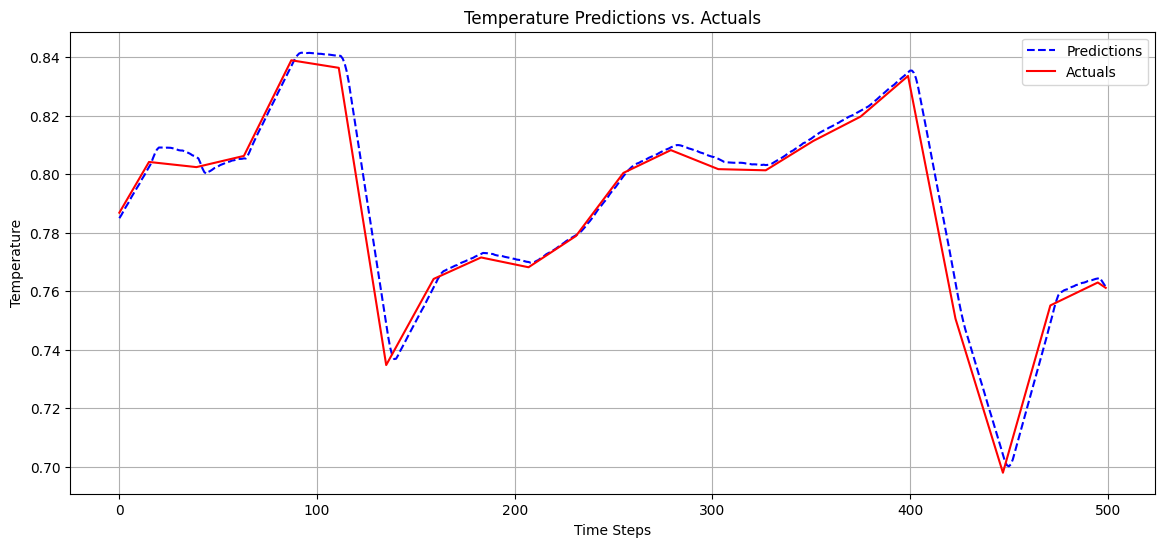

,Temperature Predictions,Temperature Actuals
0,0.784940,0.786824
1,0.786008,0.787980
2,0.787214,0.789136
3,0.788462,0.790292
4,0.789544,0.791448
...,...,...
2555,0.156885,0.148012
2556,0.148667,0.141577
2557,0.140556,0.135141
2558,0.132530,0.128706


In [150]:
plot_predictions(model, X_test, y_test)

Observations:
* The model with LSTM outperforms every model and predicts accurately because the LSTM is good at remembering the previous memory in their cell states.
* Similarly, we can use Gated Recurrent Unit (GRU) Layer in our model to get similar performance with fewer number of parameters.

<h3>6.Conclusion</h3>

* The ARIMA model struggled to capture the seasonal patterns in the dataset, resulting in flat predictions and higher error metrics.
* The SARIMA model effectively captured both trend and seasonality, providing accurate forecasts with lower error metrics compared to ARIMA.
* The VAR model performed reasonably well for multivariate time series forecasting, leveraging the relationships between multiple variables to improve predictions.
* The LSTM model outperformed all other models, accurately predicting the target variable by effectively capturing long-term dependencies and patterns in the data.
* Overall, for datasets with strong seasonal components, SARIMA and LSTM models are preferred due to their ability to handle seasonality and complex patterns, respectively.